In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## Importing and formating data

In [3]:
# import data from file
file_path = 'winequality/winequality-white.csv'
data = np.genfromtxt(file_path, delimiter=';', skip_header=1)
print(data)

[[ 5.3   0.26  0.23 ...  0.51 10.5   7.  ]
 [ 6.2   0.23  0.36 ...  0.43  8.8   6.  ]
 [ 6.9   0.21  0.81 ...  0.39  9.2   6.  ]
 ...
 [ 7.2   0.4   0.49 ...  0.42  9.3   5.  ]
 [ 6.5   0.21  0.4  ...  0.43 11.    6.  ]
 [ 7.4   0.31  0.74 ...  0.43  8.7   5.  ]]


In [4]:
# normalize parameters to [0,1]
for i in range(len(data[0,:-1])):
    mi = min(data[:,i])
    ma = max(data[:,i])
    data[:,i] -= mi
    data[:,i] /= (ma - mi)
# Shuffle the rows just in case we want to split data in parts and they're sorted
np.random.shuffle(data)
print(data)

[[0.32692308 0.38235294 0.39156627 ... 0.15116279 0.19354839 5.        ]
 [0.28846154 0.19607843 0.26506024 ... 0.1627907  0.38709677 6.        ]
 [0.29807692 0.21568627 0.21686747 ... 0.1627907  0.66129032 6.        ]
 ...
 [0.26923077 0.21568627 0.18072289 ... 0.29069767 0.22580645 5.        ]
 [0.21153846 0.15686275 0.24698795 ... 0.48837209 0.60483871 6.        ]
 [0.375      0.17647059 0.20481928 ... 0.55813953 0.56451613 6.        ]]


In [5]:
X = data[:, :-1]
y = data[:, -1].astype(int)

## Finding optimal kernel hyperparameters

In [6]:
'''
#parameters = {'C':[0.01, 0.1, 1, 10, 100], 'gamma':[0.01, 0.1, 1, 10, 100]}
#parameters = {'C':[1, 1.2, 1.3, 1.4, 1.6], 'gamma':[8, 9, 10, 11, 13]}
parameters = {'C':[2.1, 2.3, 2.4, 2.5, 2.7], 'gamma':[65, 68, 70, 72, 75]}

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=123)
scores = np.zeros((len(parameters['C']), len(parameters['gamma'])))

for iC, C in enumerate(parameters['C']):
    for ig, gamma in enumerate(parameters['gamma']):
        model = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X_train, y_train)
        pred = model.predict(X_test)
        for i in range(len(y_test)):
            scores[iC, ig] += (pred[i] - y_test[i]) ** 2

opt_indices = np.unravel_index(np.argmin(scores), scores.shape)
C_opt = parameters['C'][opt_indices[0]]           # white: 2.4  red: 1.3
gamma_opt = parameters['gamma'][opt_indices[1]]   # white: 72   red: 10

print(scores)
print('best score: ', scores[opt_indices])
print("C_opt     = ", C_opt)
print("gamma_opt = ", gamma_opt)
'''

[[511. 504. 509. 508. 506.]
 [509. 504. 506. 509. 509.]
 [506. 504. 507. 510. 504.]
 [504. 506. 508. 508. 501.]
 [508. 506. 500. 503. 502.]]
best score:  500.0
C_opt     =  2.7
gamma_opt =  70


## Training the model

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

model = svm.SVC(kernel='rbf', gamma=gamma_opt, C=C_opt).fit(X_train, y_train)

pred = model.predict(X_test)

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
print('Accuracy: ', "%.2f" % (accuracy*100))
print('F1: ', "%.2f" % (f1*100))



Accuracy:  65.41
F1:  64.36


### Confusion matrix

In [8]:
conf_mtrx = np.zeros((10, 10))
for i in range(len(y_test)):
    conf_mtrx[pred[i]-1, y_test[i]-1] += 1

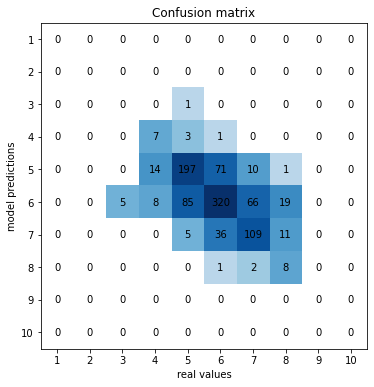

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(conf_mtrx, interpolation='nearest', cmap='Blues', norm=mcolors.LogNorm(vmin=0.1, vmax=conf_mtrx.max()))

for i in range(conf_mtrx.shape[0]):
    for j in range(conf_mtrx.shape[1]):
        plt.text(j, i, "{:.0f}".format(conf_mtrx[i, j]), ha='center', va='center', color='black')

#plt.colorbar()
plt.xticks(np.arange(0, conf_mtrx.shape[1], 1), np.arange(1, conf_mtrx.shape[1]+1, 1))
plt.yticks(np.arange(0, conf_mtrx.shape[0], 1), np.arange(1, conf_mtrx.shape[0]+1, 1))
plt.xlabel('real values')
plt.ylabel('model predictions')
plt.title('Confusion matrix')
plt.show()

### Sensitivity analysis

In [10]:
importances = np.zeros(len(X[0,:]))

for i in range(len(importances)):
    shuffled = X_test.copy()
    column = shuffled[:, i]
    np.random.shuffle(column)
    shuffled[:, i] = column

    pred_shf = model.predict(shuffled)
    acc_shf = accuracy_score(y_test, pred_shf)
    importances[i] = accuracy - acc_shf
    print(acc_shf)

importances /= np.std(importances)

print(importances)

0.5897959183673469
0.5683673469387756
0.6142857142857143
0.5938775510204082
0.6244897959183674
0.5928571428571429
0.5653061224489796
0.6234693877551021
0.5408163265306123
0.5520408163265306
0.49387755102040815
[1.71011572 2.2801543  1.05864307 1.60153695 0.78719613 1.62868164
 2.36158838 0.81434082 3.01306104 2.7144694  4.26171696]


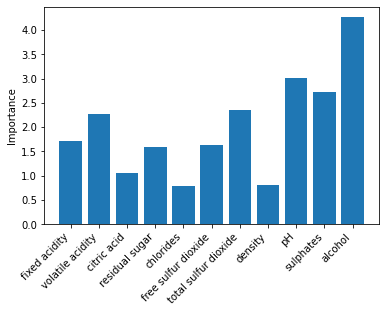

In [11]:
features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
plt.bar(features, importances)
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()